# 0.) Load libraries/datasets

In [1]:
# Load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from itertools import product
from os.path import isdir, isfile

import librosa
import librosa.display

# Set up datapath
base_path = './datasets/petsounds/cats_dogs/'

if not isdir(base_path):
    print(f"The dataset path {base_path} doesn't seem to exist. Please make sure the path to the data is correct.")
    
# Get dictionary of sounds
cat_file = 'cat_{}.wav'
dog_file = 'dog_barking_{}.wav'

pet_sounds = {'cat': [], 'dog': []}
for i in range(0, 168):
    this_cat = base_path + cat_file.format(i)
    if isfile(this_cat):
        pet_sounds['cat'].append(this_cat)
        
    this_dog = base_path + dog_file.format(i)
    if isfile(this_dog):
        pet_sounds['dog'].append(this_dog)

# 1.) Pre-process a single file using 20 frequency bins, and 2000 Hz sampling frequency.

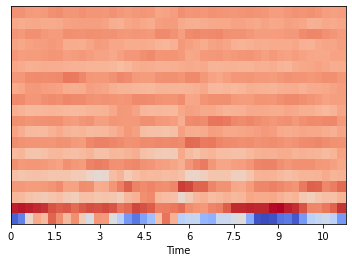

In [2]:
SAMPLING_FRQ = 2000
BINS = 20

# Process the first cat file
x, fs = librosa.load(pet_sounds['cat'][0], sr=SAMPLING_FRQ)
mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=BINS)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

# 2.) Process each into X and Y matrices. Apply a classifier and comment on results.

### Some setup

In [3]:
# Up sampling frequency to 4k
SAMPLING_FRQ = 4000

# Generator function to get all dogs/cats files and label
def get_pet():
    for pet in ['cat', 'dog']:
        for i in range(0, len(pet_sounds[pet])):
            yield(pet_sounds[pet][i], pet)
        
    return None

### Convert all sounds in pet_sounds to waveforms

In [4]:
%%time

spec_pet_sounds = {'cat': [], 'dog': []}
for sound, pet in get_pet():
    wf, _ = librosa.load(sound, sr=SAMPLING_FRQ)
    
    # trim leading zeros
    wf = np.trim_zeros(wf, 'f')
    
    spec_pet_sounds[pet].append(wf)

# save changes
pet_sounds = spec_pet_sounds

Wall time: 20.5 s


### Pad sound files to max length

In [5]:
# determine max length
max_len = 0
for wf, _ in get_pet():
    max_len = len(wf) if len(wf) > max_len else max_len
    
# pad to max length
ext_pet_sounds = {'cat': [], 'dog': []}
for wf, pet in get_pet():

    if len(wf) < max_len:
        wf = np.pad(wf, (0, max_len), 'constant', constant_values=(0,0))
        
    ext_pet_sounds[pet].append(wf)
    
# save changes
pet_sounds = ext_pet_sounds

### Get a DataFrame and then Matricies

In [8]:
# Process into Dataframe for personal sanity
pet_sounds_dict = None

for wf, pet in get_pet():
    mfccs = librosa.feature.mfcc(wf, sr=SAMPLING_FRQ, n_mfcc=BINS)
    
    # initialize dictionary if necessary
    if pet_sounds_dict is None:
        pet_sounds_dict = {}
        for i in range(len(mfccs)):
            pet_sounds_dict[f'MFCC_{i}'] = []
        pet_sounds_dict['Class'] = []

    # fill dictionary
    for i in range(len(mfccs)):
        pet_sounds_dict[f'MFCC_{i}'].append(mfccs[i])
    # binarize the Class column
    pet_sounds_dict['Class'].append(0 if pet == 'cat' else 1)

# Make df
pet_sounds_df = pd.DataFrame(pet_sounds_dict)
   
#display(pet_sounds_df)

In [9]:
# Now actually make matricies (am dummy and couldn't get this right without a Dataframe)
X = pet_sounds_df.loc[:, pet_sounds_df.columns != 'Class'].values
Y = pet_sounds_df.loc[:, pet_sounds_df.columns == 'Class'].values.ravel()

### Do some sklearn